# Assignment 1

**Author:** Tingjun Yuan

## Preparation

First things first, import necessary libraries:

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError   # For cleaning up corrupted images
import random    # To randomly pick up images

Download and unzip the image resource, then link the `PetImages` directory to the location the same as this notebook:

```sh
ln -s kagglecatsanddogs_3367a/PetImages PetImages
```

## Experiment 1: Train a CNN model

### Filter out corrupted images

In [2]:
# This cell is different from that in the tutorial because it fails to detact
# corrupted JPEG files.

def filter_and_clean_images(dirname):
    num_skipped = 0
    subdirs = os.listdir(dirname)
    for folder_name in subdirs:
        folder_path = os.path.join(dirname, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                # Try to open the image
                with Image.open(fpath) as img:
                    # Force loading of image data to trigger exceptions if it's bad
                    img.verify()
                # Reopen and save to clean it
                with Image.open(fpath) as img:
                    img.save(fpath, "JPEG")
            except (UnidentifiedImageError, OSError, ValueError):
                num_skipped += 1
                os.remove(fpath)

    print(f"Deleted {num_skipped} corrupted or unreadable images.")

In [3]:
filter_and_clean_images("PetImages")

Deleted 0 corrupted or unreadable images.


### Generate a Dataset

In [4]:
image_size = (180, 180)
batch_size = 128

def generate_dataset(dir_name):
    

    train_ds, val_ds = keras.utils.image_dataset_from_directory(
        dir_name,
        labels="inferred",
        validation_split=0.2,
        subset="both",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    return (train_ds, val_ds)

In [5]:
train_ds, val_ds = generate_dataset("PetImages")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2025-04-01 10:35:57.848890: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-01 10:35:57.848911: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-04-01 10:35:57.848917: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
I0000 00:00:1743496557.848931  284405 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743496557.848949  284405 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualize the data

Here are the first 9 images in the training dataset.

2025-04-01 10:35:58.003248: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


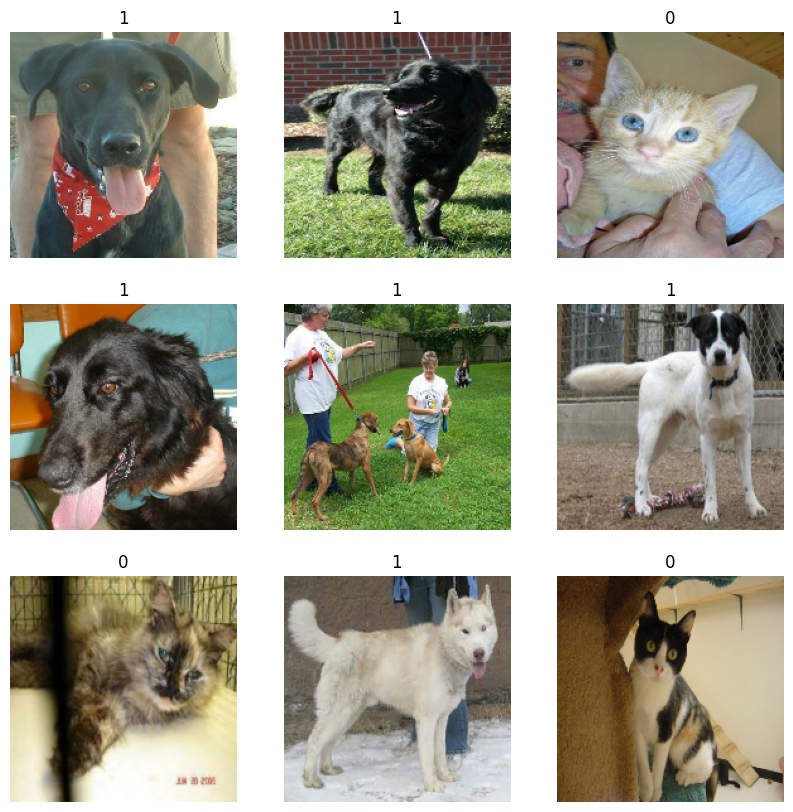

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Using image data augmentation

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-04-01 10:35:58.520160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


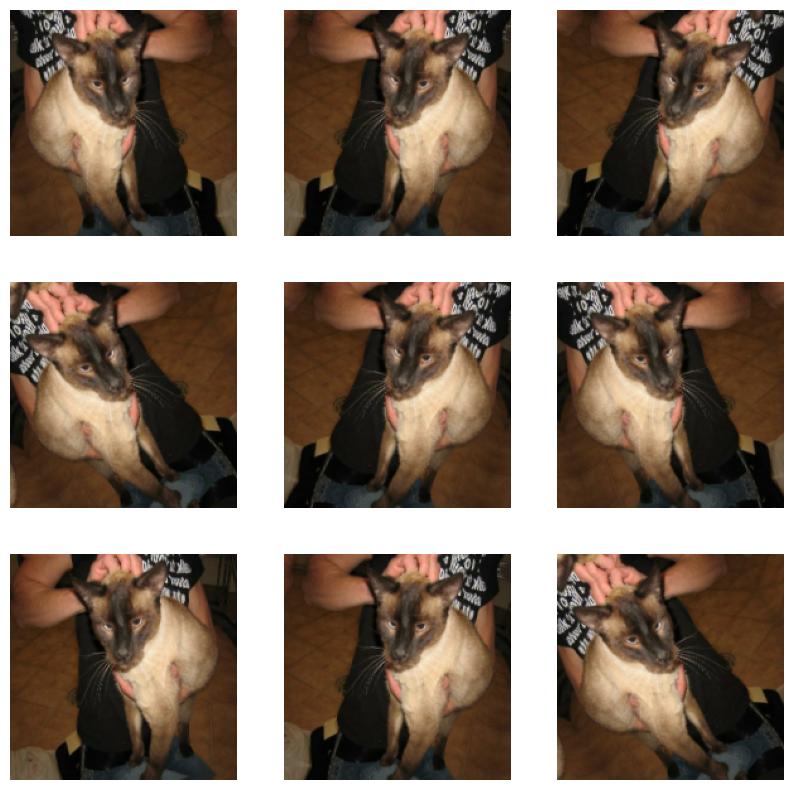

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Configure the dataset for performance

In [9]:
def configure_dataset(train_ds, val_ds):
    # Apply `data_augmentation` to the training images.
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    # Prefetching samples in GPU memory helps maximize GPU utilization.
    train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
    return (train_ds, val_ds)

In [10]:
train_ds, val_ds = configure_dataset(train_ds, val_ds)

### Build a model

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same", name="conv2d_128")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same", name=f"conv2d_{size}")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None, name="dense_1")(x)
    return keras.Model(inputs, outputs)

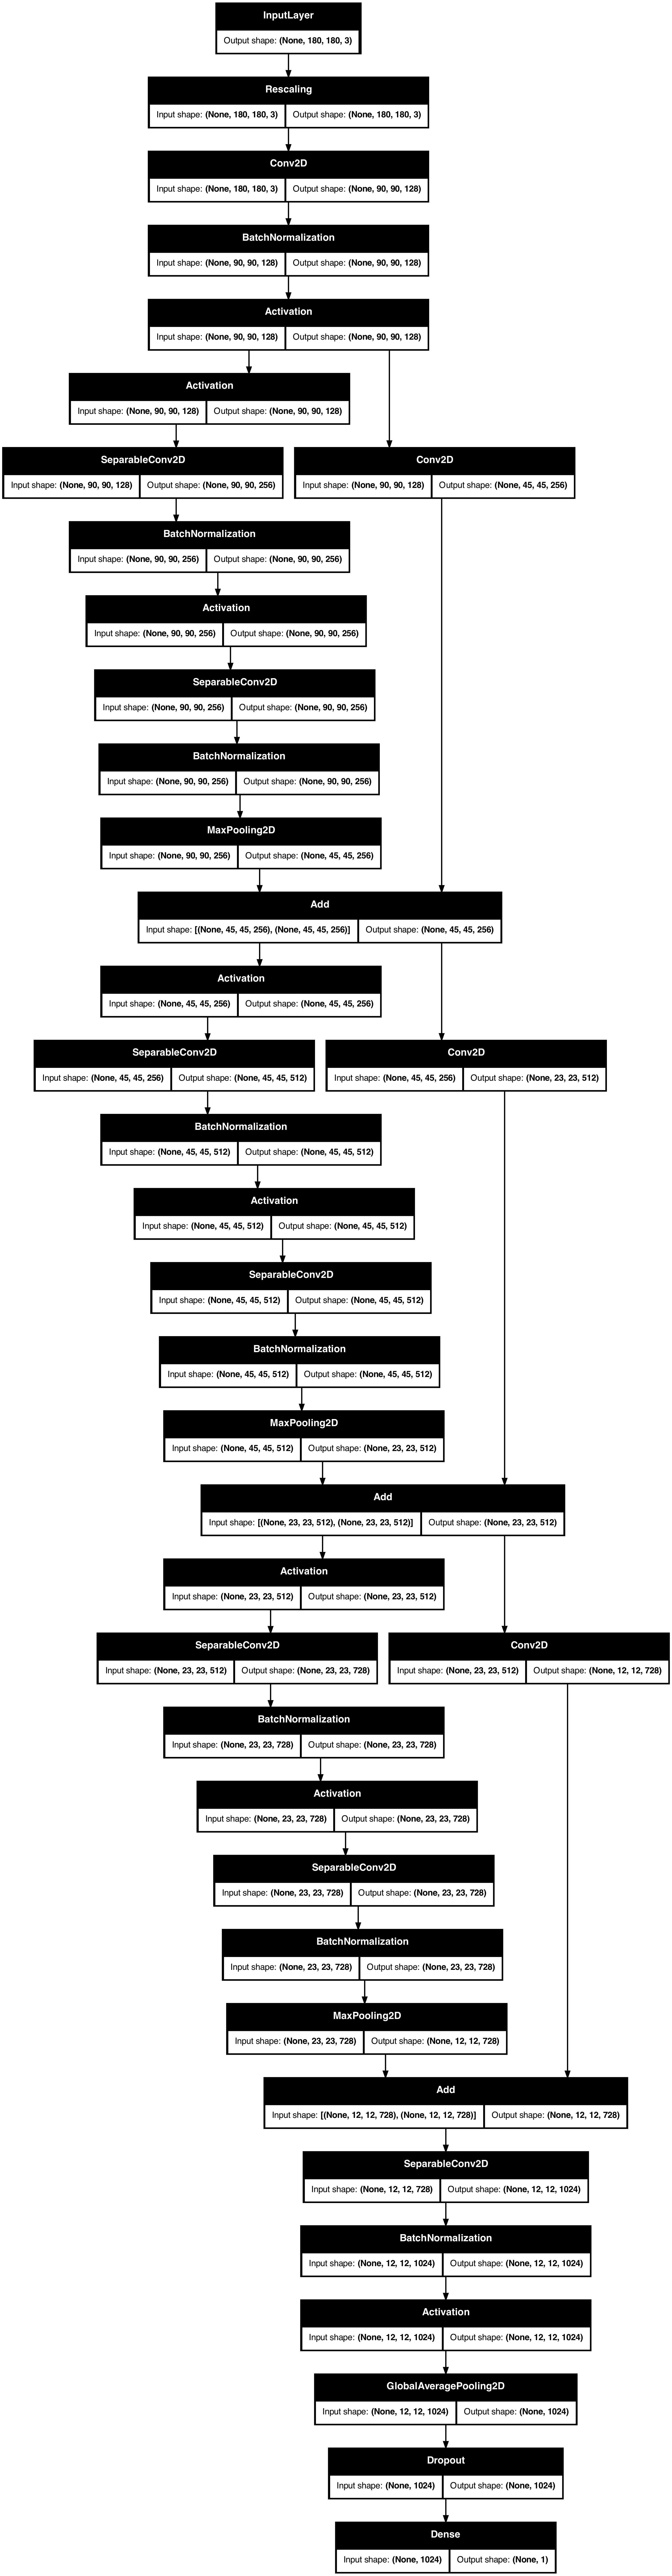

In [12]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### Train the model

In [13]:
def train_model_cat_dog(model, train_ds, val_ds, epochs, checkpoint_path, learning_rate=0.0001):
    # Create the directory for model checkpoints
    try:
        os.mkdir(path=checkpoint_path)
    except FileExistsError:
        pass

    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path + "/save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

In [14]:
train_model_cat_dog(model=model, train_ds=train_ds, val_ds=val_ds, epochs=25, checkpoint_path="cat_dog_epoch")

Epoch 1/25


2025-04-01 10:36:00.058265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 755ms/step - acc: 0.6190 - loss: 0.6348 - val_acc: 0.4957 - val_loss: 0.6988
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 788ms/step - acc: 0.7121 - loss: 0.5387 - val_acc: 0.4957 - val_loss: 0.7165
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 788ms/step - acc: 0.7576 - loss: 0.4748 - val_acc: 0.4957 - val_loss: 0.7111
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 772ms/step - acc: 0.7911 - loss: 0.4278 - val_acc: 0.4957 - val_loss: 0.7414
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 771ms/step - acc: 0.8242 - loss: 0.3770 - val_acc: 0.5224 - val_loss: 1.1724
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 776ms/step - acc: 0.8410 - loss: 0.3416 - val_acc: 0.8499 - val_loss: 0.3309
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 776ms/step - acc: 0.8547 - loss: 0.3135 - val_acc: 0.7392 - val_loss: 0.4721
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 775ms/step - acc: 0.8686 - loss: 0.2945 - val_acc: 0.8761 - val_loss: 0.2947
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━

In [15]:
try:
    os.mkdir(path="models")
except FileExistsError:
    pass
model.save(filepath="models/cats_dogs_1.keras", overwrite=True)

### Run inference on new data

In [16]:
def run_inference(img_path, model):
    img = keras.utils.load_img(img_path, target_size=image_size)
    plt.imshow(img)

    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
This image is 99.67% cat and 0.33% dog.


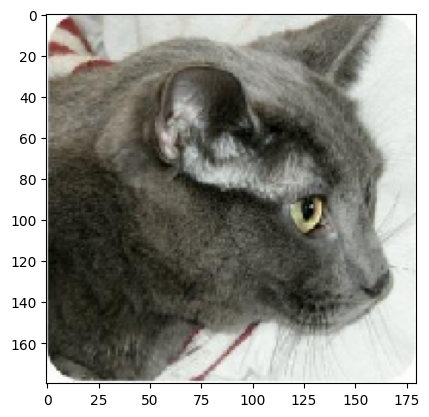

In [17]:
run_inference("PetImages/Cat/6779.jpg", model)

### Train a model on the Stanford Dogs dataset

First, prepare the images using the following commands:

```sh
wget 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
tar -xf images.tar
mv Images StanfordDogs
```

Then, train a model based on that:

In [18]:
filter_and_clean_images("StanfordDogs")

Deleted 0 corrupted or unreadable images.


In [19]:
train_ds, val_ds = generate_dataset("StanfordDogs")
class_names = train_ds.class_names

Found 20579 files belonging to 120 classes.
Using 16464 files for training.
Using 4115 files for validation.


In [20]:
train_ds, val_ds = configure_dataset(train_ds, val_ds)
model = make_model(input_shape=image_size + (3,), num_classes=120)

In [21]:
def train_model_stanford_dog(model, train_ds, val_ds, epochs, checkpoint_path, learning_rate=0.0001):
    # Create the directory for model checkpoints
    try:
        os.mkdir(path=checkpoint_path)
    except FileExistsError:
        pass

    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path + "/save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

In [22]:
train_model_stanford_dog(model=model, train_ds=train_ds, val_ds=val_ds, epochs=25, checkpoint_path="stanford_dogs_epoch")

Epoch 1/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 776ms/step - acc: 0.0178 - loss: 4.8015 - val_acc: 0.0122 - val_loss: 4.7862
Epoch 2/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 806ms/step - acc: 0.0341 - loss: 4.5658 - val_acc: 0.0122 - val_loss: 4.7885
Epoch 3/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 105s 809ms/step - acc: 0.0546 - loss: 4.4000 - val_acc: 0.0124 - val_loss: 4.8121
Epoch 4/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 103s 796ms/step - acc: 0.0746 - loss: 4.2471 - val_acc: 0.0136 - val_loss: 4.8997
Epoch 5/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 102s 792ms/step - acc: 0.0884 - loss: 4.1076 - val_acc: 0.0197 - val_loss: 4.9705
Epoch 6/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 801ms/step - acc: 0.1045 - loss: 3.9708 - val_acc: 0.0605 - val_loss: 4.3450
Epoch 7/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 803ms/step - acc: 0.1208 - loss: 3.8553 - val_acc: 0.0668 - val_loss: 4.4192
Epoch 8/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 103s 798ms/step - acc: 0.1417 - loss: 3.7326 - val_acc: 0.1108 - val_loss: 3.9130
Epoch 9/25
129/129 ━━━━━

Finally, save the model to a file:

In [23]:
model.save(filepath="models/stanford_dogs_1.keras", overwrite=True)

Test this model:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Top 10 most possible belonging classes:
4.3814	n02112018-Pomeranian
3.4084	n02113023-Pembroke
2.3700	n02110806-basenji
2.1295	n02115641-dingo
2.1014	n02085620-Chihuahua
1.7581	n02086079-Pekinese
1.7297	n02094114-Norfolk_terrier
1.6584	n02099601-golden_retriever
1.5881	n02094258-Norwich_terrier
1.5291	n02088364-beagle


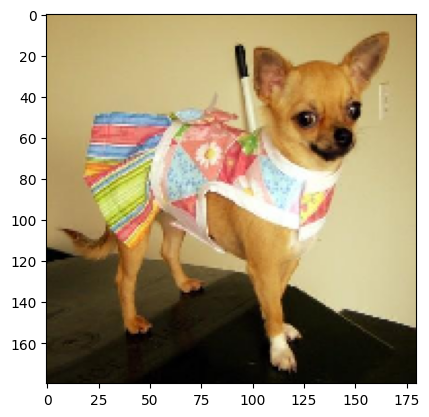

In [24]:
img = keras.utils.load_img("StanfordDogs/n02085620-Chihuahua/n02085620_949.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)[0]
# Use the previously extracted class names
predictions_with_labels = [(predictions[i], class_names[i]) for i in range(len(predictions))]
predictions_with_labels.sort(key=lambda x: -x[0])
print("Top 10 most possible belonging classes:")
for i in range(10):
    p = predictions_with_labels[i]
    print(f"{p[0]:.4f}\t{p[1]}")

## Experiment 2: Replace only the output layer of the model

Here is the model loaded:

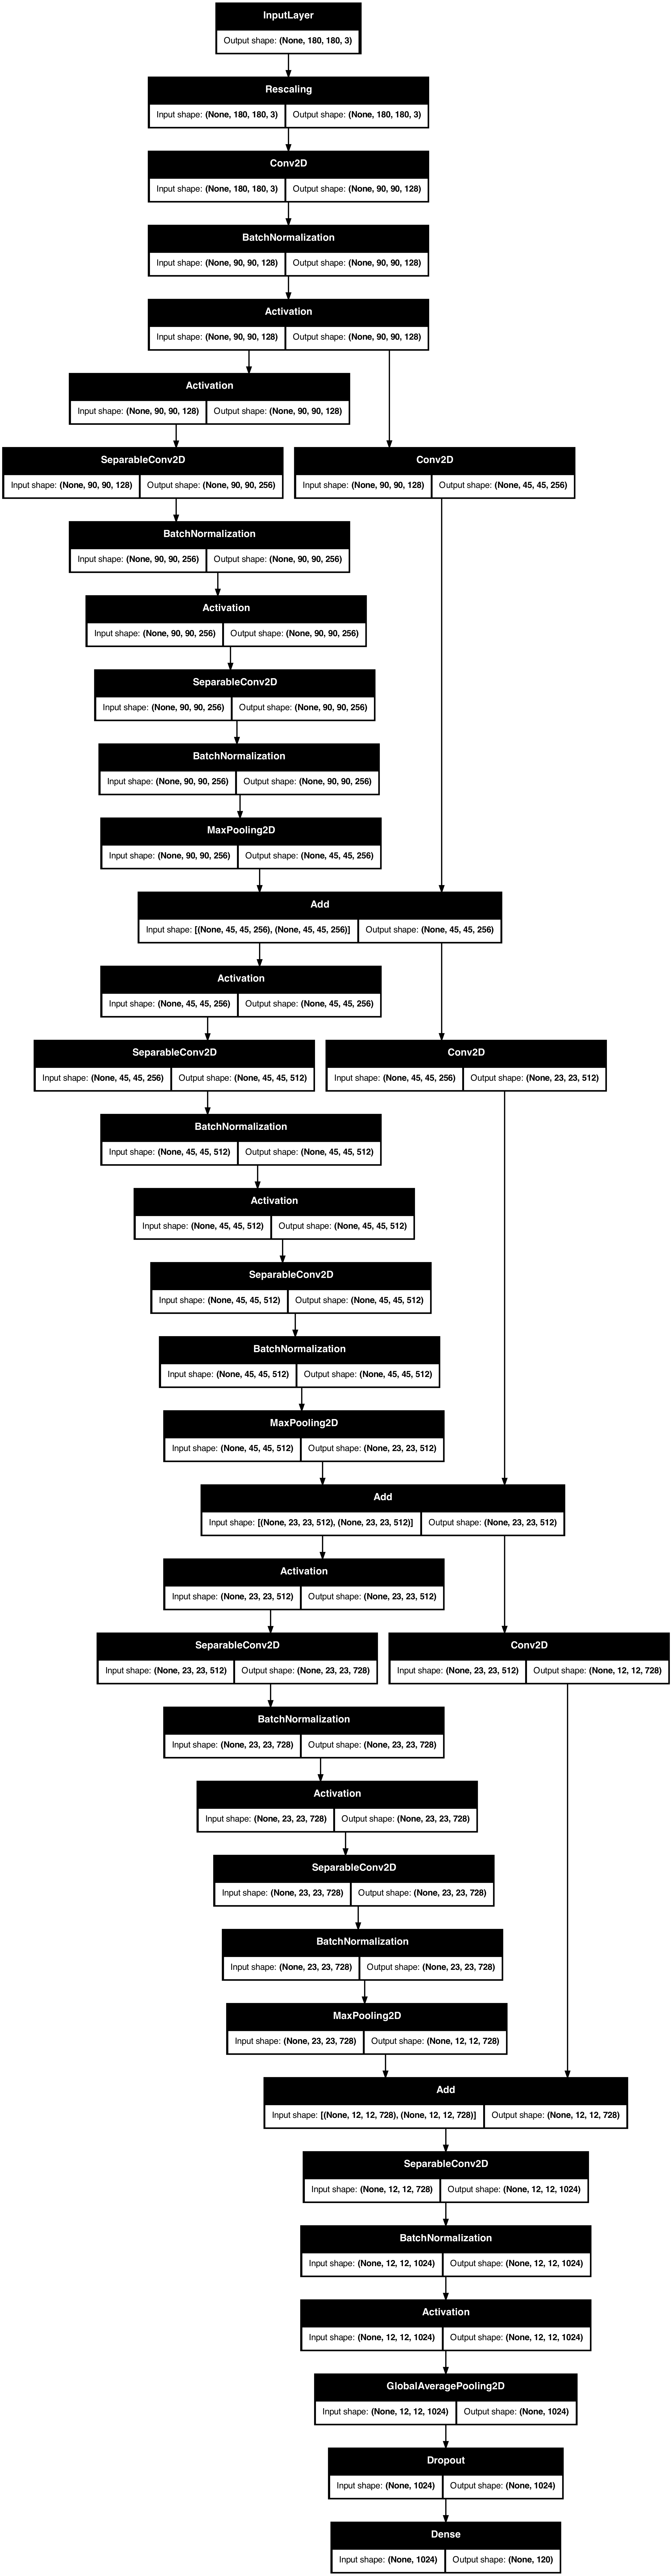

In [25]:
model = keras.models.load_model(filepath="models/stanford_dogs_1.keras")
keras.utils.plot_model(model, show_shapes=True)

We then replace the `Dense` layer to make it suitable for cats-and-dogs problem:

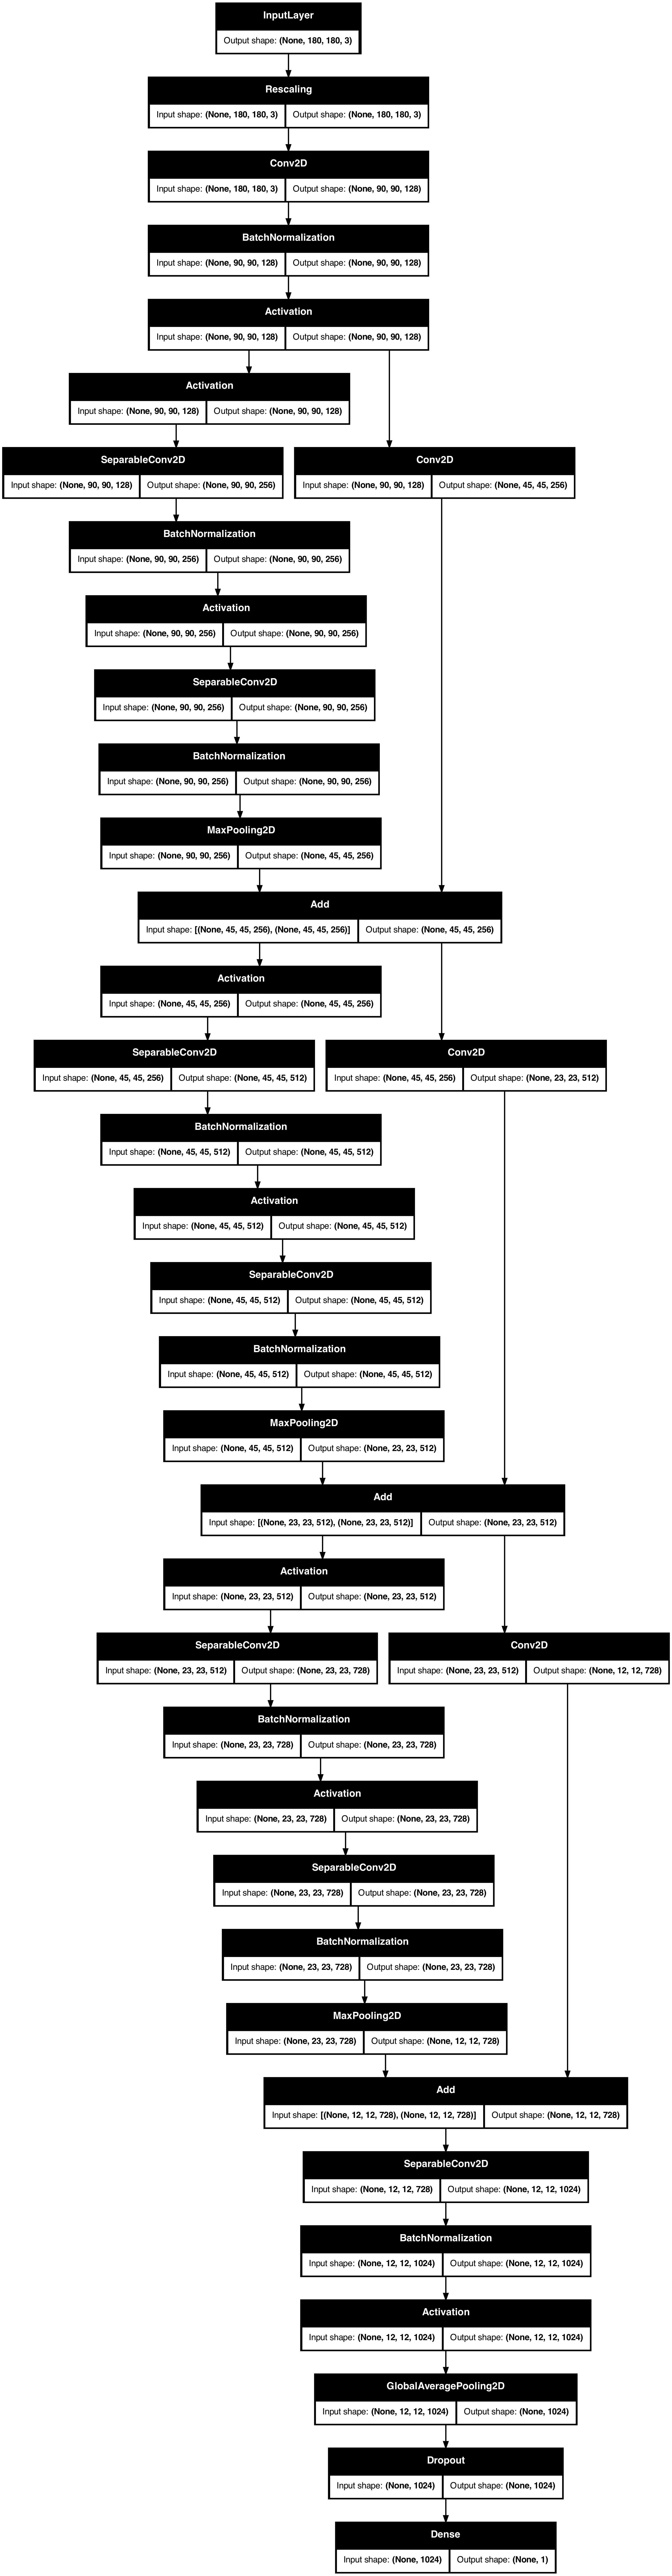

In [26]:
x = model.layers[-2].output
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(model.input, outputs)
keras.utils.plot_model(model, show_shapes=True)

Let's then apply the dataset and train the model for 50 epochs:

In [27]:
train_ds, val_ds = generate_dataset("PetImages")
train_ds, val_ds = configure_dataset(train_ds, val_ds)
train_model_cat_dog(model=model, train_ds=train_ds, val_ds=val_ds, epochs=50, checkpoint_path="cat_dog_epoch_2")
model.save(filepath="models/cats_dogs_2.keras", overwrite=True)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 780ms/step - acc: 0.7383 - loss: 0.5274 - val_acc: 0.7663 - val_loss: 0.6175
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 786ms/step - acc: 0.8351 - loss: 0.3546 - val_acc: 0.8093 - val_loss: 0.3644
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 787ms/step - acc: 0.8723 - loss: 0.2914 - val_acc: 0.7435 - val_loss: 0.4370
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 786ms/step - acc: 0.8852 - loss: 0.2593 - val_acc: 0.8695 - val_loss: 0.3388
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 785ms/step - acc: 0.8955 - loss: 0.2369 - val_acc: 0.8674 - val_loss: 0.3565
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 783ms/step - acc: 0.9081 - loss: 0.2107 - val_acc: 0.8806 - val_loss: 0.3164
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 779ms/step - acc: 0.9126 - loss: 0.2017 - val_acc: 0.8492 - val_loss: 0.2838
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
This image is 100.00% cat and 0.00% dog.


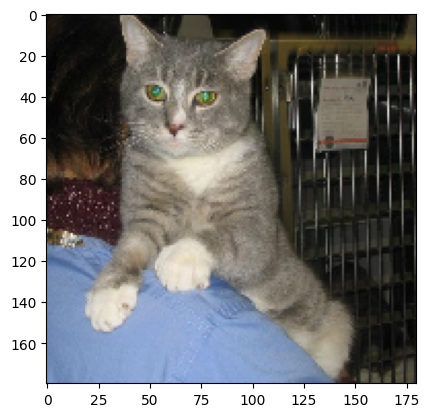

In [28]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Cat/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image is 5.49% cat and 94.51% dog.


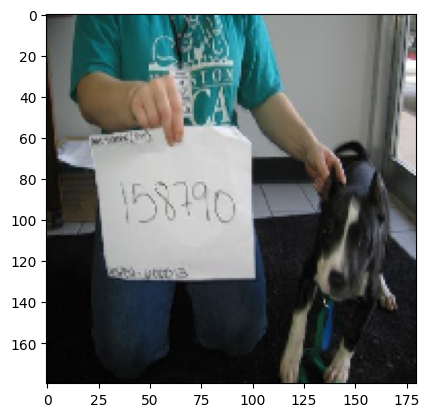

In [29]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Dog/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

## Experiment 3: Replace the output layer of the model, as well as the first two convolutional layers

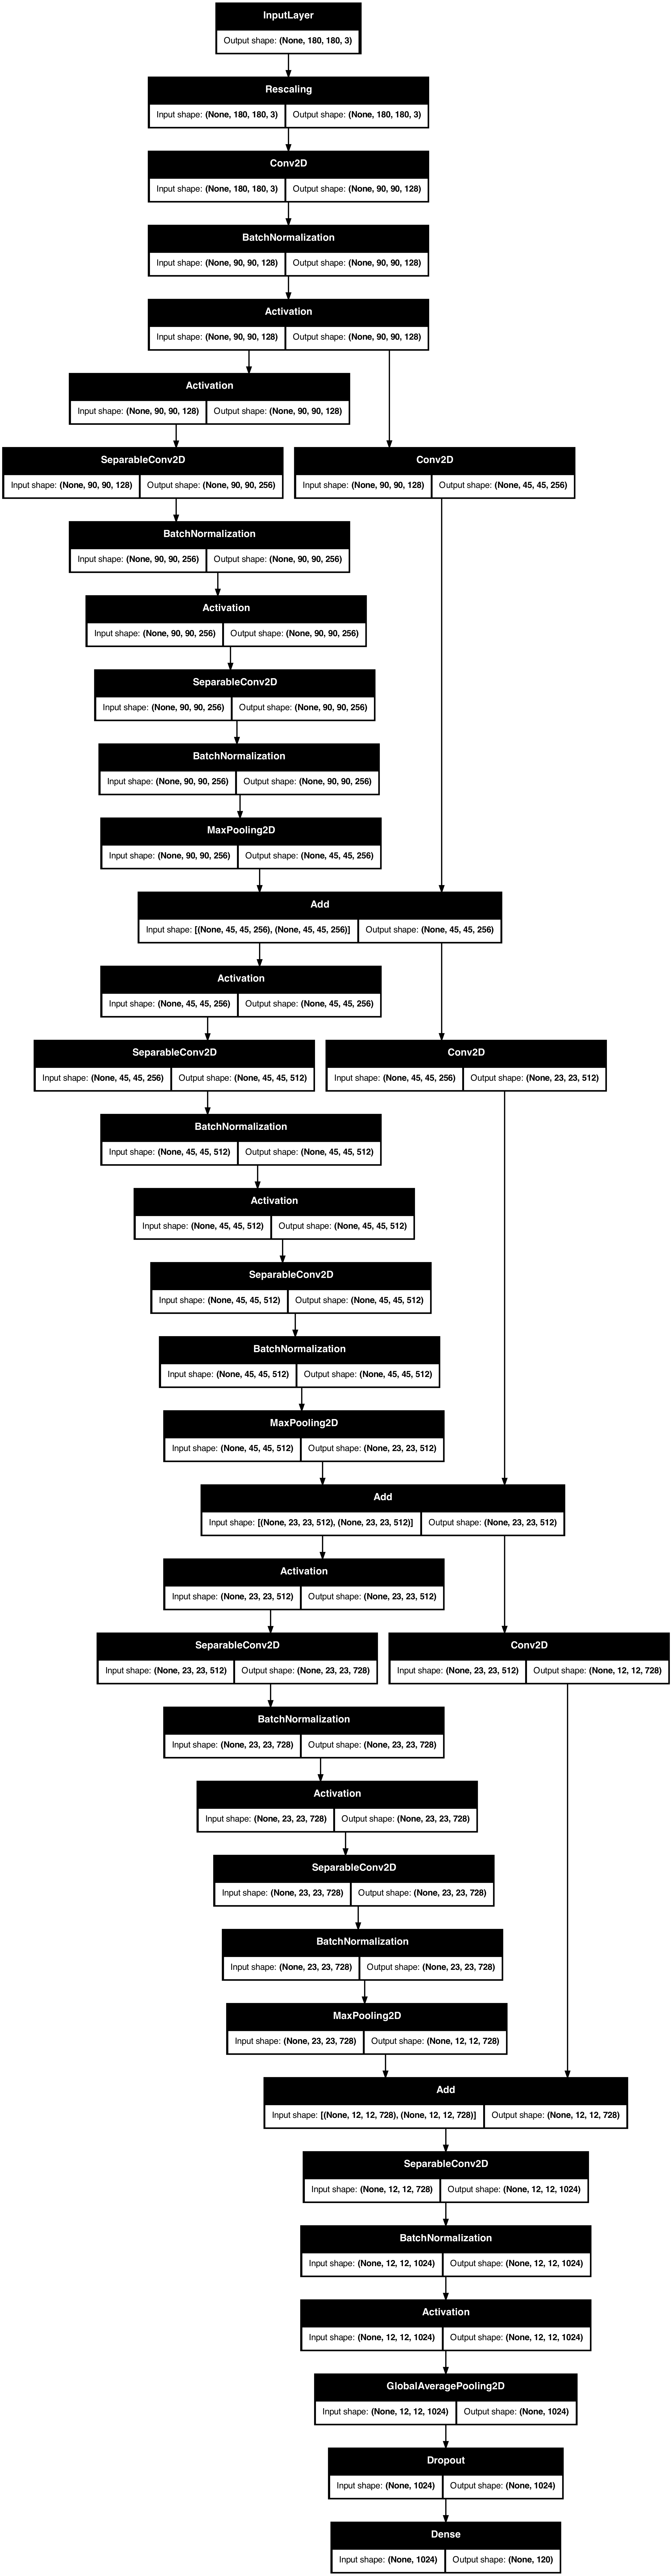

In [30]:
model = keras.models.load_model(filepath="models/stanford_dogs_1.keras")

def clone_layer(layer):
    if layer.name == "conv2d_128":
        return layers.Conv2D(128, 3, strides=2, padding="same", name="conv2d_128")
    elif layer.name == "conv2d_256":
        return layers.Conv2D(256, 1, strides=2, padding="same", name="conv2d_256")
    elif layer.name == "dense_0":
        return layers.Dense(1, activation=None)
    else:
        return layer

model = keras.models.clone_model(model, clone_function=clone_layer)
keras.utils.plot_model(model, show_shapes=True)

In [31]:
train_ds, val_ds = generate_dataset("PetImages")
train_ds, val_ds = configure_dataset(train_ds, val_ds)
train_model_cat_dog(model=model, train_ds=train_ds, val_ds=val_ds, epochs=50, checkpoint_path="cat_dog_epoch_3")
model.save(filepath="models/cats_dogs_3.keras", overwrite=True)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 120)

In [ ]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Cat/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

In [ ]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Dog/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

## Experiment 4: Replace the output layer of the model, as well as the two last convolutional layers

In [ ]:
model = keras.models.load_model(filepath="models/stanford_dogs_1.keras")

def clone_layer(layer):
    if layer.name == "conv2d_512":
        return layers.Conv2D(128, 3, strides=2, padding="same", name="conv2d_512")
    elif layer.name == "conv2d_728":
        return layers.Conv2D(256, 1, strides=2, padding="same", name="conv2d_728")
    elif layer.name == "dense_0":
        return layers.Dense(1, activation=None)
    else:
        return layer

model = keras.models.clone_model(model, clone_function=clone_layer)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
train_ds, val_ds = generate_dataset("PetImages")
train_ds, val_ds = configure_dataset(train_ds, val_ds)
train_model_cat_dog(model=model, train_ds=train_ds, val_ds=val_ds, epochs=50, checkpoint_path="cat_dog_epoch_4")
model.save(filepath="models/cats_dogs_4.keras", overwrite=True)

In [ ]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Cat/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

In [ ]:
while True:
    num = random.randint(0, 12499)
    try:
        run_inference(f"PetImages/Dog/{num}.jpg", model)
    except FileNotFoundError:
        continue
    break

## References:

* https://keras.io/examples/vision/image_classification_from_scratch/
* https://www.tensorflow.org/datasets/catalog/stanford_dogs